# Setup

In [111]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

if IS_COLAB or IS_KAGGLE:
    %pip install -q -U tfx
    print("You can safely ignore the package incompatibility errors.")

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "data"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## SequenceExample protobufを使ったリストのリストの処理

前回はTensorFlow ProtobufのExampleを使用したが、それを使うと煩雑になってしまう場合

すなわち、リストのリストを扱う場合の方法を説明する

（例えば、それぞれの文書は文のリスト(FeatureLists)、個々の文は単語のリスト(FeatureList)として表現）

SequenceExample Protobufは次のように定義されている

```proto
syntax = "proto3";

message FeatureList { repeated Feature feature = 1; };
message FeatureLists { map<string, FeatureList> feature_list = 1; };
message SequenceExample {
  Features context = 1;
  FeatureLists feature_lists = 2;
};
```

In [112]:
#from tensorflow.train import FeatureList, FeatureLists, SequenceExample
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Feature, Features, Example
FeatureList = tf.train.FeatureList
FeatureLists = tf.train.FeatureLists
SequenceExample = tf.train.SequenceExample

context = Features(feature={
    "author_id": Feature(int64_list=Int64List(value=[123])),
    "title": Feature(bytes_list=BytesList(value=[b"A", b"desert", b"place", b"."])),
    "pub_date": Feature(int64_list=Int64List(value=[1623, 12, 25]))
})

# featureの作成
content = [["When", "shall", "we", "three", "meet", "again", "?"],
           ["In", "thunder", ",", "lightning", ",", "or", "in", "rain", "?"]]
comments = [["When", "the", "hurlyburly", "'s", "done", "."],
            ["When", "the", "battle", "'s", "lost", "and", "won", "."]]

def words_to_feature(words):
    return Feature(bytes_list=BytesList(value=[word.encode("utf-8")
                                               for word in words]))

# FeatureList(Features)の作成
content_features = [words_to_feature(sentence) for sentence in content]
comments_features = [words_to_feature(comment) for comment in comments]

# FeatureListの作成            
sequence_example = SequenceExample(
    context=context,
    feature_lists=FeatureLists(feature_list={
        "content": FeatureList(feature=content_features),
        "comments": FeatureList(feature=comments_features)
    }))

In [113]:
sequence_example

context {
  feature {
    key: "author_id"
    value {
      int64_list {
        value: 123
      }
    }
  }
  feature {
    key: "pub_date"
    value {
      int64_list {
        value: 1623
        value: 12
        value: 25
      }
    }
  }
  feature {
    key: "title"
    value {
      bytes_list {
        value: "A"
        value: "desert"
        value: "place"
        value: "."
      }
    }
  }
}
feature_lists {
  feature_list {
    key: "comments"
    value {
      feature {
        bytes_list {
          value: "When"
          value: "the"
          value: "hurlyburly"
          value: "\'s"
          value: "done"
          value: "."
        }
      }
      feature {
        bytes_list {
          value: "When"
          value: "the"
          value: "battle"
          value: "\'s"
          value: "lost"
          value: "and"
          value: "won"
          value: "."
        }
      }
    }
  }
  feature_list {
    key: "content"
    value {
      feature {
      

In [114]:
# 文字列の形にシリアライズされたものを返す
serialized_sequence_example = sequence_example.SerializeToString()

In [115]:
serialized_sequence_example

b"\nL\n\x14\n\x08pub_date\x12\x08\x1a\x06\n\x04\xd7\x0c\x0c\x19\n \n\x05title\x12\x17\n\x15\n\x01A\n\x06desert\n\x05place\n\x01.\n\x12\n\tauthor_id\x12\x05\x1a\x03\n\x01{\x12\xd0\x01\nb\n\x08comments\x12V\n&\n$\n\x04When\n\x03the\n\nhurlyburly\n\x02's\n\x04done\n\x01.\n,\n*\n\x04When\n\x03the\n\x06battle\n\x02's\n\x04lost\n\x03and\n\x03won\n\x01.\nj\n\x07content\x12_\n*\n(\n\x04When\n\x05shall\n\x02we\n\x05three\n\x04meet\n\x05again\n\x01?\n1\n/\n\x02In\n\x07thunder\n\x01,\n\tlightning\n\x01,\n\x02or\n\x02in\n\x04rain\n\x01?"

In [116]:
# 記述辞書を定義する
context_feature_descriptions = {
    "author_id": tf.io.FixedLenFeature([], tf.int64, default_value=0),
    "title": tf.io.VarLenFeature(tf.string),
    "pub_date": tf.io.FixedLenFeature([3], tf.int64, default_value=[0, 0, 0]),
}
sequence_feature_descriptions = {
    "content": tf.io.VarLenFeature(tf.string),
    "comments": tf.io.VarLenFeature(tf.string),
}

# SequenceExample protobufをパースし、シリアライズする、Exampleと関数が異なることに注意
parsed_context, parsed_feature_lists = tf.io.parse_single_sequence_example(
    serialized_sequence_example, context_feature_descriptions,
    sequence_feature_descriptions)

In [117]:
parsed_context

{'title': <tensorflow.python.framework.sparse_tensor.SparseTensor at 0x2479de252e0>,
 'author_id': <tf.Tensor: shape=(), dtype=int64, numpy=123>,
 'pub_date': <tf.Tensor: shape=(3,), dtype=int64, numpy=array([1623,   12,   25], dtype=int64)>}

In [118]:
# titleの読み出し
parsed_context["title"].values

<tf.Tensor: shape=(4,), dtype=string, numpy=array([b'A', b'desert', b'place', b'.'], dtype=object)>

In [119]:
parsed_feature_lists

{'comments': <tensorflow.python.framework.sparse_tensor.SparseTensor at 0x2479ddc4d60>,
 'content': <tensorflow.python.framework.sparse_tensor.SparseTensor at 0x2479ddc4a00>}

In [120]:
# contentの読み出し
print(tf.RaggedTensor.from_sparse(parsed_feature_lists["content"]))

<tf.RaggedTensor [[b'When', b'shall', b'we', b'three', b'meet', b'again', b'?'],
 [b'In', b'thunder', b',', b'lightning', b',', b'or', b'in', b'rain', b'?']]>


# 13.3 入力特徴量の前処理

### 標準化層

多くの場合、Numpyなどを使って標準化するが、ここではモデルの中で標準化する方法を紹介する

モデル中でデータを標準化するには、前処理層としてNormalizationレイヤを使用する

これを使うには、まずレイヤを作り、それに標準化させるデータをadapt()メソッドで適応させる

In [121]:
from tensorflow.keras.layers import Normalization

train_val_data = np.array([[0., 7., 4.],
                       [2., 9., 6.],
                       [0., 7., 4.],
                       [2., 9., 6.]], dtype='float32')  # 訓練データと検証データ(標準化させる元データ)
train_data = np.array([[0., 7., 4.]], dtype='float32')  # 訓練データのみ
std_layer = Normalization(axis=-1)  # レイヤを作成
std_layer.adapt(train_val_data)  # 標準化するため、平均と標準偏差を計算
std_layer(train_data)  # 訓練データの標準化

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-1., -1., -1.]], dtype=float32)>

最後にモデルに、レイヤとして組み込む

In [122]:
model = keras.Sequential()
model.add(std_layer)

## 13.3.1 ワンホットベクトルを使ったカテゴリ特徴量のエンコード

カテゴリ特徴量をワンホットベクトル（(0,0,0,1,0)など1つの成分が1で残りの成分が全て0であるようなベクトル）に変える

ここで、訓練データでは含まれないが、テストデータでは含まれているカテゴリがある場合に備えて、num_oov_buckets分だけ余分に「ハッシュ(インデックス)」を作成している

In [123]:
vocab = ["<1H OCEAN", "INLAND", "NEAR OCEAN", "NEAR BAY", "ISLAND"]  # すべてのカテゴリのリストである「語彙」の定義
indices = tf.range(len(vocab), dtype=tf.int64)  # vocabと同じ大きさのテンソルを作る
table_init = tf.lookup.KeyValueTensorInitializer(vocab, indices) # 語彙とテンソルを結びつけた辞書型を作る
num_oov_buckets = 2  # 語彙外(oov:out-of-vocabulary)の数
table = tf.lookup.StaticVocabularyTable(table_init, num_oov_buckets)
  # カテゴリ数 + oovの数だけ「ハッシュ」を作成する
  # oovバケットのインデックスは5と6(未知カテゴリがあったときに割り当てる)

次に、ルックアップテーブルを使って少数のカテゴリ特徴量をワンホットベクトルにエンコードする

In [124]:
categories = tf.constant(["NEAR BAY", "DESERT", "INLAND", "INLAND"])  # テストデータなどのカテゴリ特徴量(DESERTは新たな特徴量)
cat_indices = table.lookup(categories)
cat_indices

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([3, 5, 1, 1], dtype=int64)>

NEAR BAYがindex3に、DESERTがindex5に、INLANDがindex1にマッピングされている
これをワンホットベクトルに直すと以下の様になる

In [125]:
cat_one_hot = tf.one_hot(cat_indices, depth=len(vocab) + num_oov_buckets)
cat_one_hot

<tf.Tensor: shape=(4, 7), dtype=float32, numpy=
array([[0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.]], dtype=float32)>

## 13.3.2 埋め込みを使ったカテゴリ特徴量のエンコード

カテゴリ数が多い(50以上)場合は、埋め込み(embedding)を使うと良い

埋め込みとは、カテゴリを表現する訓練可能な密なベクトルのことである

最も一般的な例は、自然言語処理に使われる単語埋め込みである

単語埋め込みの「埋め込み空間」の一例を以下に示す

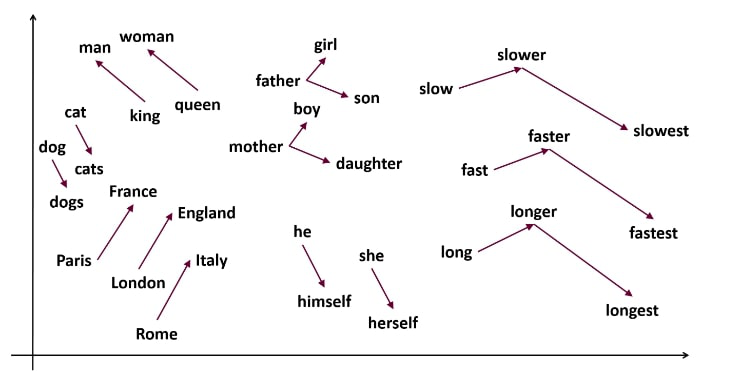

In [126]:
import IPython.display as display
from PIL import Image
display.display(Image.open('word_vector.jpg'))

似た単語が単に近く配置されるだけでなく、埋め込み空間の意味のある軸に沿って組織されるのが特徴である

例えば、King - Man + Womanを計算すると、Queenになっている

(ただし、ManがDoctorに、WomanがNurseに対応するようにも学習してしまうため、学習に偏見をもってしまうこともある)

このような埋め込みを使って、カテゴリ特徴量をベクトル化する

ここでは、2次元埋め込みを利用する

In [127]:
vocab = ["<1H OCEAN", "INLAND", "NEAR OCEAN", "NEAR BAY", "ISLAND"]  # すべてのカテゴリのリストである「語彙」の定義
num_oov_buckets = 2  # 語彙外(oov:out-of-vocabulary)の数

embedding_dim = 2  # 埋め込み行列の次元(ハイパーパラメータ)
embed_init = tf.random.uniform([len(vocab) + num_oov_buckets, embedding_dim])  # ランダムに初期化したテンソル
embedding_matrix = tf.Variable(embed_init)  # 6×2の行列
embedding_matrix

<tf.Variable 'Variable:0' shape=(7, 2) dtype=float32, numpy=
array([[0.23285627, 0.4295962 ],
       [0.8159542 , 0.9740679 ],
       [0.5594299 , 0.39859426],
       [0.9253955 , 0.3285359 ],
       [0.6476785 , 0.10627615],
       [0.92928874, 0.9186193 ],
       [0.8589885 , 0.4936428 ]], dtype=float32)>

これで、インデックスに対応する埋め込み行列(初期値)が設定された

以下で新たなカテゴリ特徴量に埋め込みベクトルを割り当てる

In [128]:
categories = tf.constant(["NEAR BAY", "DESERT", "INLAND", "INLAND"])  # テストデータなどのカテゴリ特徴量(DESERTは新たな特徴量)
cat_indices = table.lookup(categories)  # インデックスに割り当て

tf.nn.embedding_lookup(embedding_matrix, cat_indices)  #インデックスに対応する埋め込みベクトルを読み出す

<tf.Tensor: shape=(4, 2), dtype=float32, numpy=
array([[0.9253955 , 0.3285359 ],
       [0.92928874, 0.9186193 ],
       [0.8159542 , 0.9740679 ],
       [0.8159542 , 0.9740679 ]], dtype=float32)>

現在は、TextVectorizationクラスにより、モデル中にこの操作を組み込むことができる

以下は、tensorflowホームページよりの引用である

In [129]:
text_dataset = tf.data.Dataset.from_tensor_slices(["foo", "bar", "baz"])
max_features = 5000  # カテゴリ特徴量の数の最大値
max_len = 4  # 表現ベクトルの数

# レイヤの作成
vectorize_layer = tf.keras.layers.TextVectorization(
 max_tokens=max_features,
 output_mode='int',
 output_sequence_length=max_len)

# adapt()メソッドでデータ読み込み
vectorize_layer.adapt(text_dataset.batch(64))

# モデルの作成
model = tf.keras.models.Sequential()

# インプット層の作成
model.add(tf.keras.Input(shape=(1,), dtype=tf.string))

# ベクトル化層の挿入
model.add(vectorize_layer)

# データの入力
input_data = [["foo qux bar"], ["qux baz"]]
model.predict(input_data)

array([[2, 1, 4, 0],
       [1, 3, 0, 0]], dtype=int64)

上記のように、空欄で区切られた単語を読み取り、ベクトルを適切に返す